<a href="https://colab.research.google.com/github/Ihsan1331/Casava/blob/main/Cassava_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Mounting Goole Drive

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Load Package

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd

# 3. Load Dataset

In [ ]:
!unzip /content/drive/MyDrive/ML/Cassava/sorted_data_image.zip

In [ ]:
# Define your image dataset directory
image_data_dir = '/content/sorted_data_image'

# Create an image data generator
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split = 0.2)

In [ ]:
# Load and split the data into training and validation sets
train_data = image_generator.flow_from_directory(
    image_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle = True# This will load the training set
)

testing_data = image_generator.flow_from_directory(
    image_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle = True # This will load the validation set
)


Found 14352 images belonging to 5 classes.
Found 3586 images belonging to 5 classes.


In [ ]:
train_data.class_indices

{'Cassava_Bacterial_Blight': 0,
 'Cassava_Brown_Streak_Disease': 1,
 'Cassava_Green_Mottle': 2,
 'Cassava_Healthy': 3,
 'Cassava_Mosaic_Disease': 4}

[0. 0. 0. 0. 1.]


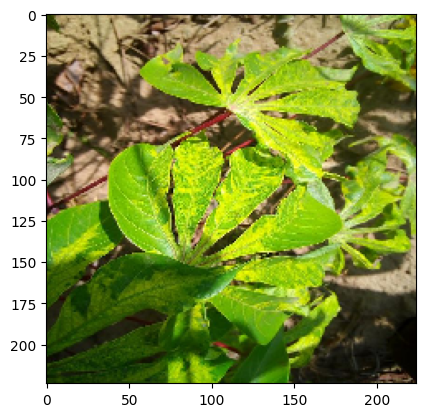

In [ ]:
print(train_data[0][1][0]) #index awal buat gambar sama label, index ke dua buat batch, index ke tiga buat sampel gambar
plt.imshow(train_data[0][0][0])
plt.show()

# 4. Exploratory Data Analysis

In [ ]:
pd.DataFrame(train_data.classes).value_counts()

4    8822
3    1733
2    1595
1    1465
0     737
dtype: int64

In [ ]:
pd.DataFrame(testing_data.classes).value_counts()

4    2205
3     433
2     398
1     366
0     184
dtype: int64

In [ ]:
import numpy as np

# Calculate class weights to handle imbalance
class_weights = {}
total_samples = len(train_data.labels)
num_classes = len(train_data.class_indices)

class_counts = np.bincount(train_data.labels)
max_count = np.max(class_counts)

for i in range(num_classes):
    class_weights[i] = max_count / class_counts[i]

# Load and split the data into training and validation sets with class weights
train_data = image_generator.flow_from_directory(
    image_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,  # Shuffle the data
    class_weight=class_weights  # Pass class weights
)

testing_data = image_generator.flow_from_directory(
    image_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,  # Shuffle the data
    class_weight=class_weights  # Pass class weights
)


# 5. ResNet Model

In [ ]:
#load renset50 bobot dari imagenet
resnet_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Buat Resnet bisa di train ulang
resnet_base.trainable = True

x = tf.keras.layers.GlobalAveragePooling2D()(resnet_base.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model_resnet = Model(resnet_base.input,x)
# Display model summary
model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

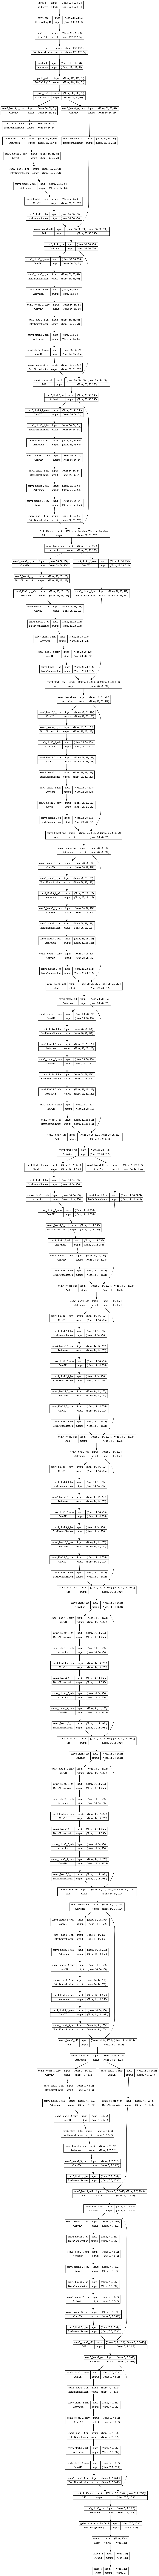

In [ ]:
plot_model(model_resnet, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_resnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history_resnet = model_resnet.fit(train_data, epochs=10, validation_data = testing_data)

Epoch 1/10
449/449 [==============================] - 247s 428ms/step - loss: 0.8983 - accuracy: 0.6775 - val_loss: 4.0339 - val_accuracy: 0.1207
Epoch 2/10
449/449 [==============================] - 179s 398ms/step - loss: 0.7120 - accuracy: 0.7379 - val_loss: 1.6275 - val_accuracy: 0.3965
Epoch 3/10
449/449 [==============================] - 177s 395ms/step - loss: 0.6358 - accuracy: 0.7676 - val_loss: 1.4835 - val_accuracy: 0.3848
Epoch 4/10
449/449 [==============================] - 175s 388ms/step - loss: 0.5961 - accuracy: 0.7841 - val_loss: 1.3405 - val_accuracy: 0.5251
Epoch 5/10
449/449 [==============================] - 174s 388ms/step - loss: 0.5323 - accuracy: 0.8082 - val_loss: 0.7917 - val_accuracy: 0.7161
Epoch 6/10
449/449 [==============================] - 174s 386ms/step - loss: 0.5120 - accuracy: 0.8172 - val_loss: 18.1850 - val_accuracy: 0.6525
Epoch 7/10
449/449 [==============================] - 174s 388ms/step - loss: 0.4774 - accuracy: 0.8257 - val_loss: 0.8697 

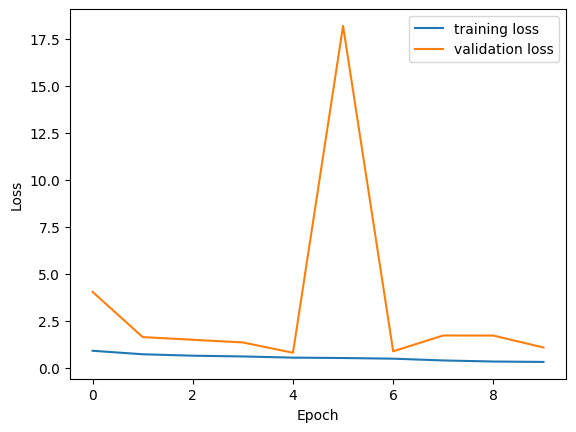

In [ ]:
plt.plot(history_resnet.history['loss'], label = 'training loss')
plt.plot(history_resnet.history['val_loss'], label = 'validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

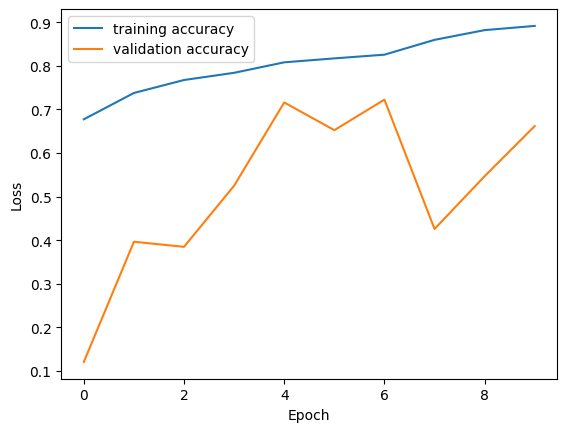

In [ ]:
plt.plot(history_resnet.history['accuracy'], label = 'training accuracy')
plt.plot(history_resnet.history['val_accuracy'], label = 'validation accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
resnet_pred = model_resnet.predict(testing_data)

113/113 [==============================] - 21s 184ms/step


In [ ]:
resnet_pred_list = []
for i in resnet_pred:
  resnet_pred_list.append(np.argmax(i))

In [ ]:
accuracy_score(testing_data.labels, resnet_pred_list)

0.36837702175125486

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testing_data.labels, resnet_pred_list)

array([[   4,   12,   54,   21,   93],
       [   9,   31,   84,   34,  208],
       [   6,   33,  106,   34,  219],
       [  11,   36,  136,   29,  221],
       [  59,  187,  585,  223, 1151]])

# 6. DenseNet Model

In [ ]:
densenet_base = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(densenet_base.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model_densenet = Model(densenet_base.input, x)
model_densenet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_6[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.687516 to fit



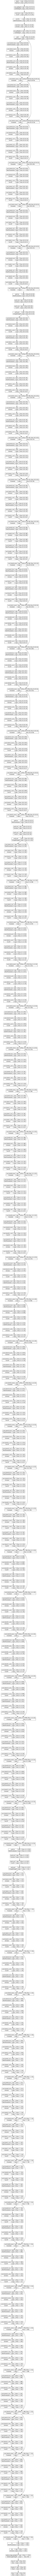

In [ ]:
plot_model(model_densenet, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_densenet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history_densenet = model_densenet.fit(train_data, epochs=10, validation_data = testing_data)

Epoch 1/10
449/449 [==============================] - 259s 425ms/step - loss: 0.8185 - accuracy: 0.6983 - val_loss: 3.5740 - val_accuracy: 0.1838
Epoch 2/10
449/449 [==============================] - 178s 397ms/step - loss: 0.6531 - accuracy: 0.7605 - val_loss: 0.7272 - val_accuracy: 0.7270
Epoch 3/10
449/449 [==============================] - 181s 402ms/step - loss: 0.5792 - accuracy: 0.7916 - val_loss: 1.1914 - val_accuracy: 0.7083
Epoch 4/10
449/449 [==============================] - 179s 399ms/step - loss: 0.5371 - accuracy: 0.8089 - val_loss: 1.1714 - val_accuracy: 0.5661
Epoch 5/10
449/449 [==============================] - 181s 403ms/step - loss: 0.4967 - accuracy: 0.8246 - val_loss: 0.6048 - val_accuracy: 0.7878
Epoch 6/10
449/449 [==============================] - 181s 403ms/step - loss: 0.4523 - accuracy: 0.8380 - val_loss: 2.0408 - val_accuracy: 0.4108
Epoch 7/10
449/449 [==============================] - 179s 398ms/step - loss: 0.4198 - accuracy: 0.8495 - val_loss: 0.8983 -

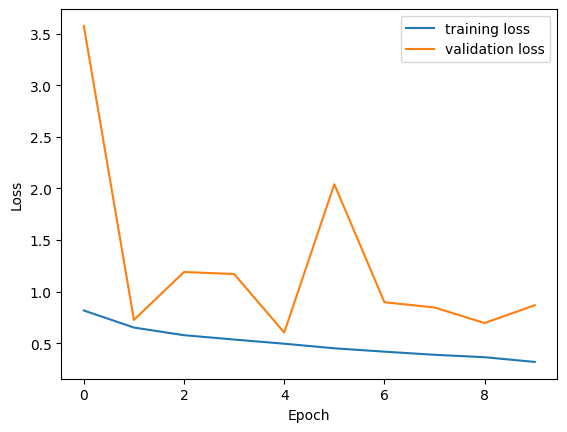

In [ ]:
plt.plot(history_densenet.history['loss'], label = 'training loss')
plt.plot(history_densenet.history['val_loss'], label = 'validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

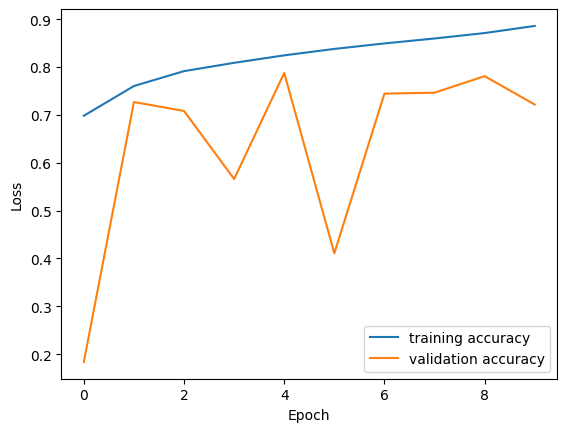

In [ ]:
plt.plot(history_densenet.history['accuracy'], label = 'training accuracy')
plt.plot(history_densenet.history['val_accuracy'], label = 'validation accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
densenet_pred = model_densenet.predict(testing_data)

113/113 [==============================] - 20s 179ms/step


In [ ]:
densenet_pred_list = []
for i in densenet_pred:
  densenet_pred_list.append(np.argmax(i))

In [ ]:
accuracy_score(testing_data.labels, densenet_pred_list)

0.36614612381483547

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testing_data.labels, densenet_pred_list)

array([[  11,   28,   53,    7,   85],
       [  34,   34,   87,   18,  193],
       [  26,   44,   86,   25,  217],
       [  34,   30,  113,   34,  222],
       [ 155,  187,  568,  147, 1148]])

In [ ]:
densenet_pred

array([[7.5142686e-03, 9.9192894e-01, 2.8490156e-04, 8.1074220e-05,
        1.9087462e-04],
       [3.7360859e-08, 8.0154916e-07, 4.0964903e-03, 6.6611574e-06,
        9.9589598e-01],
       [4.6071491e-05, 2.1002267e-04, 5.3657293e-01, 5.9651164e-04,
        4.6257442e-01],
       ...,
       [2.0268852e-04, 8.8982587e-04, 5.6247342e-01, 8.6843474e-03,
        4.2774972e-01],
       [2.6891220e-01, 3.4738678e-01, 6.3986257e-02, 3.1589901e-01,
        3.8157664e-03],
       [1.2631465e-09, 8.1193470e-08, 2.1683284e-04, 1.8272608e-07,
        9.9978286e-01]], dtype=float32)

In [ ]:
print(densenet_pred_list)

[1, 4, 2, 4, 2, 4, 4, 2, 1, 4, 1, 4, 4, 2, 4, 4, 4, 4, 4, 2, 2, 4, 1, 4, 4, 4, 1, 4, 1, 2, 3, 4, 4, 1, 4, 4, 4, 4, 2, 4, 2, 4, 4, 1, 1, 1, 2, 4, 0, 1, 2, 2, 3, 2, 4, 3, 4, 0, 4, 4, 0, 2, 4, 4, 2, 4, 4, 2, 4, 4, 4, 4, 1, 2, 2, 4, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 4, 4, 4, 2, 2, 4, 1, 2, 1, 4, 4, 0, 4, 4, 3, 2, 2, 4, 4, 4, 1, 4, 2, 4, 4, 4, 2, 4, 0, 1, 2, 1, 4, 4, 4, 0, 3, 4, 2, 4, 1, 2, 1, 2, 2, 2, 2, 4, 4, 2, 1, 2, 4, 0, 4, 4, 4, 2, 4, 2, 1, 4, 4, 4, 2, 4, 4, 2, 1, 2, 2, 4, 1, 2, 4, 4, 4, 2, 4, 2, 4, 1, 4, 4, 3, 1, 4, 4, 4, 0, 2, 2, 1, 1, 3, 2, 4, 2, 4, 4, 4, 4, 0, 2, 4, 2, 4, 4, 4, 2, 4, 2, 1, 0, 4, 4, 2, 2, 4, 4, 2, 0, 3, 2, 1, 4, 4, 4, 4, 4, 2, 2, 4, 0, 4, 4, 4, 4, 4, 1, 4, 2, 2, 2, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 4, 0, 2, 4, 4, 2, 4, 4, 4, 4, 1, 4, 2, 4, 4, 2, 4, 2, 3, 2, 3, 2, 2, 4, 4, 1, 4, 2, 4, 3, 4, 4, 4, 4, 2, 2, 2, 2, 4, 1, 4, 2, 4, 4, 1, 4, 2, 3, 2, 2, 4, 1, 1, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 1, 4, 4, 2, 0, 4, 4, 4, 1, 0, 2, 2, 2, 1, 4, 2, 4, 4, 4, 4, 4, 4, 4, 1, 0, 2, 2, 3, 2, 4, 

In [ ]:
print(tf.argmax(densenet_pred, axis=1))

tf.Tensor([1 4 2 ... 2 1 4], shape=(3586,), dtype=int64)


In [ ]:
image_generator.classes[0:1000]

AttributeError: 'ImageDataGenerator' object has no attribute 'classes'